# Proposal Group 17: Mediterranean Fires

Lua Presidio, Daniel Hou, Michelle Yan



## Introdution

Forest fires are a recurring natural disaster, predicting the occurrence of fires is essential to mitigate its environmental, economic, and social risks.

Many tools like satellite imaging monitoring can predict fire risk but some areas lack the technology to utilize those tools. Thus, it’s useful to utilize a simple method of risk prediction that yields accurate results without sophisticated data. We are interested in looking at the basic weather observations to predict the occurrence of a fire.

*Can we use a combination of temperature, rain, relative humidity and wind speed to accurately predict if a fire will occur or not?*

For this project we use a dataset with 244 instances from two regions in Algeria as a case study. We will focus our predictions on the Mediterranean Basin, as they have similar fire occurrence, frequency, size, seasonality, and intensity as Algeria.


In [84]:
#The dataset contains the following attributes, but the 5 we will focus on are: 

#<ul>
#<li>  Temperature: Temperature in Celsius degrees for a particular day (ranges from 22 - 42)</li>
#<li>  RH: The concentration of water vapor present in the air expressed as a percentage (ranges from 21 - 91)</li>
#<li>  Ws: Wind speed in km/h (ranges from 6 - 29)</li>
#<li>  Rain: Total rain in mm (ranges from 0 - 16.8)</li>
#<li>  Class: Classification for a given day indicating if there was a fire (fire) or if there was not a fire (no fire)</li>
#</ul>

#All the climate observation data was collected at noon on all given days in accordance with FWI policy.

## Preliminary exploratory data analysis

In [85]:
# run first

library(tidyverse)
library(tidymodels)
library("GGally")
library(stringr)
library(repr)

In [86]:
#load from website
fire_data <- read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/00547/Algerian_forest_fires_dataset_UPDATE.csv", skip = 1)

#combine both tables and give each observation a region 
fire_data2  <- fire_data %>%
    mutate(seq = 1:nrow(fire_data)) %>%
    mutate(Region = case_when(seq < 123 ~ "Bejaia",
                              TRUE ~ "Sidi-Bel Abbes"))
#We will combine the observations from the two regions as we aren’t interested in their particular differences.

#fix one line of faulty data
fire_data_fix <- fire_data2 %>%
    filter(seq == 168) %>%
    separate(col = "DC", into = c("DC", "new"), sep = " ") %>%
    mutate(Classes = FWI)%>%
    mutate(FWI = BUI) %>%
    mutate(BUI = ISI) %>%
    mutate(ISI = new) %>%
    select(-new)
    
#remove invalid data
fire_data2 <- fire_data2[-c(123,124, 168), ] 

#insert fixed line into data
fire_data_comp <- rbind(fire_data2, fire_data_fix)

#change the vectors to the appropriate type
numerics <- c("day", "month", "year", "Temperature", "RH", "Ws", "Rain", "FFMC", "DMC", "DC", "ISI", "BUI", "FWI")

fire_data_comp <- select(fire_data_comp, -seq) %>%
    type.convert(as.is = TRUE)
fire_data_comp
    
# create training data
set.seed(10)
fire_data_split <- initial_split(fire_data_comp, prop = 0.75, strata = Classes)
fire_data_training <- training(fire_data_split)
fire_data_testing <- testing(fire_data_split)
    
# We choose to use a 75/25 split for the training/testing data because our data set only has 244 rows, which is a fairly low number of observations, so we want a sufficient number of observations to train on.    
    

Parsed with column specification:
cols(
  day = col_character(),
  month = col_character(),
  year = col_character(),
  Temperature = col_character(),
  RH = col_character(),
  Ws = col_character(),
  Rain = col_character(),
  FFMC = col_character(),
  DMC = col_character(),
  DC = col_character(),
  ISI = col_character(),
  BUI = col_character(),
  FWI = col_character(),
  Classes = col_character()
)

Warning message:
“2 parsing failures.
row col   expected     actual                                                                                                       file
123  -- 14 columns 1 columns  'https://archive.ics.uci.edu/ml/machine-learning-databases/00547/Algerian_forest_fires_dataset_UPDATE.csv'
168  -- 14 columns 13 columns 'https://archive.ics.uci.edu/ml/machine-learning-databases/00547/Algerian_forest_fires_dataset_UPDATE.csv'
”


day,month,year,Temperature,RH,Ws,Rain,FFMC,DMC,DC,ISI,BUI,FWI,Classes,Region
<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
1,6,2012,29,57,18,0.0,65.7,3.4,7.6,1.3,3.4,0.5,not fire,Bejaia
2,6,2012,29,61,13,1.3,64.4,4.1,7.6,1.0,3.9,0.4,not fire,Bejaia
3,6,2012,26,82,22,13.1,47.1,2.5,7.1,0.3,2.7,0.1,not fire,Bejaia
4,6,2012,25,89,13,2.5,28.6,1.3,6.9,0.0,1.7,0.0,not fire,Bejaia
5,6,2012,27,77,16,0.0,64.8,3.0,14.2,1.2,3.9,0.5,not fire,Bejaia
6,6,2012,31,67,14,0.0,82.6,5.8,22.2,3.1,7.0,2.5,fire,Bejaia
7,6,2012,33,54,13,0.0,88.2,9.9,30.5,6.4,10.9,7.2,fire,Bejaia
8,6,2012,30,73,15,0.0,86.6,12.1,38.3,5.6,13.5,7.1,fire,Bejaia
9,6,2012,25,88,13,0.2,52.9,7.9,38.8,0.4,10.5,0.3,not fire,Bejaia


### Exploratory table

In [87]:
#create data for temp avg, wind speed avg, rain avg, FWI avg and number of observations
fire_data_training %>%
    select(-(day:year), -(FFMC:BUI)) %>%
    group_by(Classes) %>%
    summarize(Temperature_avg = mean(Temperature),
              Ws_avg = mean(Ws),
              Rain_avg = mean(Rain),
              RH_avg = mean(RH),
              n = n())

#This table shows the means of our predictor variables: Average temperature (Celcius), wind speed (km/h), Rain (mm), and Relative Humidity (%) and shows the total number of instances for each Class.

`summarise()` ungrouping output (override with `.groups` argument)



Classes,Temperature_avg,Ws_avg,Rain_avg,RH_avg,n
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
fire,33.55769,15.21154,0.1192308,57.000,104
not fire,30.01250,15.98750,1.7312500,68.825,80


### Exploratory plots

In [88]:
# options(repr.plot.height = 20, repr.plot.width = 25)

# fire_data_training %>%
#     select(-day, -month, -year, -seq, -(FFMC:BUI)) %>%
#     ggpairs(axisLabels = "show") +
#     theme(text = element_text(size = 20))

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



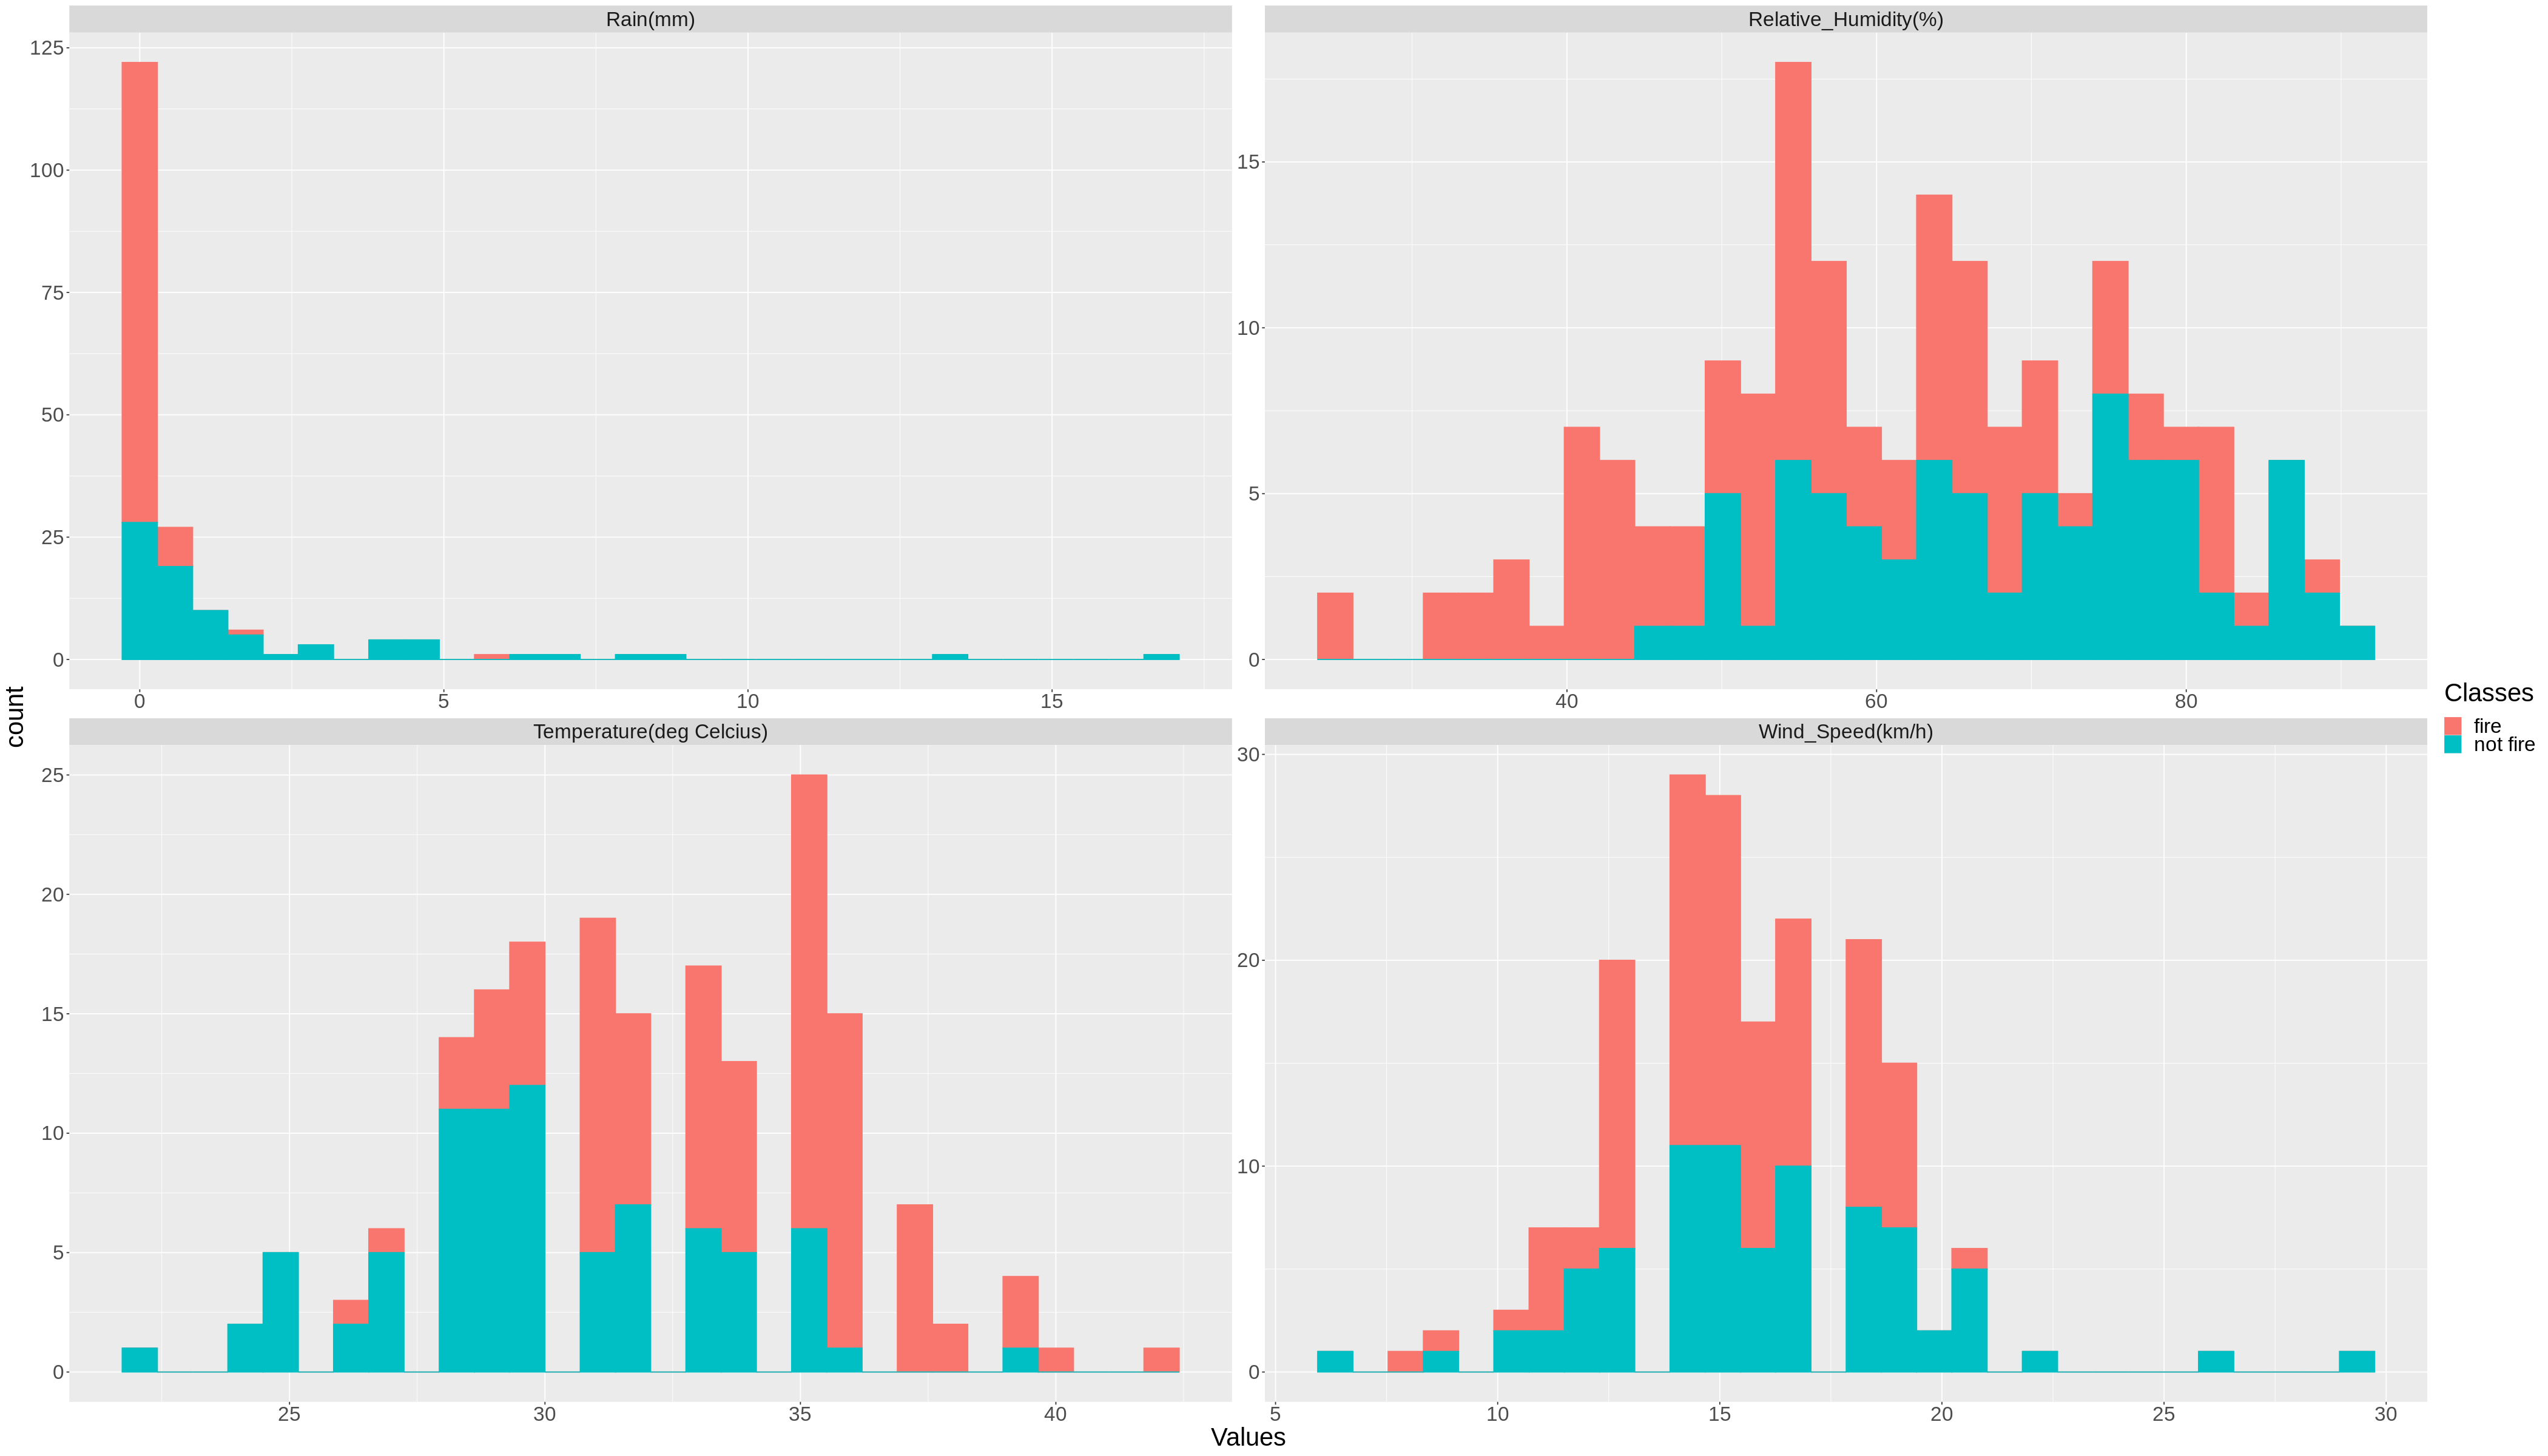

In [89]:
options(repr.plot.height = 20, repr.plot.width = 35)

# Making a plot that shows the distributions of our predictor variables. 

fire_data_training %>%
    mutate("Rain(mm)" = Rain) %>%
    mutate("Relative_Humidity(%)" = RH) %>%
    mutate("Temperature(deg Celcius)" = Temperature) %>%
    mutate("Wind_Speed(km/h)" = Ws) %>%
    select("Rain(mm)":"Wind_Speed(km/h)", Classes) %>%
    pivot_longer(- Classes,
                names_to = "variable",
                values_to = "values") %>%
    ggplot(aes(x = values, color = Classes, fill = Classes)) +
    geom_histogram() +
    facet_wrap(~ variable, scales = "free", ncol = 2) +
    xlab("Values") +
    theme(text = element_text(size = 25))



##### Rain distribution

Both classes are centered at roughly 0. The class "not fire" is more spread out than the class "fire", so "not fire" has a greater range. 

#####  Relative humidity distribution (RH)

There are more instances of "fire" when RH < 40. We see roughly the same number of instances of both classes between ~ 44 to 70, although "fire" is centered at ~55 while "not fire' is centered at ~70. At RH > 70, "not fire" instances are greater than "fire" instances. "fire" has a greater range than "not fire".

##### Temperature distribution

The range for both classes are about the same. "Not fire" is shifted towards lower temperatures, while "fire" is shifted towards higher temperatures. "fire" is centered at ~35°C and more instances occur at temperatures > 30°C. "not fire" is centered at ~28°C and more instances occur at temperatures < 30°C.

##### Wind speed distribution (Ws)

There is a relatively even number of instances for "fire" and "not fire" in the 10km/h - 20km/h range and therefore are both centered at ~15-16 km/h. "Not fire" has a few instances of high and low wind speeds, so it has a greater range than "fire". 

## Methods

##### Variables used 

We used the RH, Rain, Temperature and WS columns as those are the 4 variables we're comparing to predict whether or not a fire occurs.

##### Obtaining and visualizing the results

We will visualize the results through a histogram of each of our variables and colour the bars based on classes.

We will use multivariate K-NN classification to make our predictions and compute the distance between the new observation and the observations in the training set using the formula sqrt((xa - xb)^2 + (ya - yb)^2 + ... + (za-zb)^2). Next, we sort the resulting table in ascending order and choose the top K rows from the table. Finally, we classify the new observation based on majority votes.


## Expected outcomes and significance:




We expect to create an accurate fire prediction model based on our chosen variables and expect our findings to help others predict the occurrence of a fire based on the same variables.

The future question this could lead to is regarding the strength in relationship between one of the weather observations and different Fire Code values. For example, is temperature more significant than relative humidity in the risk of fire? Another possible question would be if from these observations alone (without utilizing additional codes) can we predict a FWI value?
